In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


E0000 00:00:1743881924.755504  223597 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743881924.759561  223597 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743881924.771087  223597 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743881924.771110  223597 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743881924.771113  223597 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743881924.771116  223597 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# GLOBAL VARIABLES
dataset = "animals"
base_dir = os.path.join("datasets", dataset)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
augmented_dir = os.path.join(base_dir, "aug")
os.makedirs(augmented_dir, exist_ok=True)

models_dir = os.path.join("models", dataset)
os.makedirs(models_dir, exist_ok=True)

metadata_file = os.path.join(models_dir, "metadata.csv")
metrics_file = os.path.join(models_dir, "metrics.csv")

# HYPERPARAMETERS
HYPERPARAMETERS = {
    "model_version": 2,
    # Image processing
    "img_width": 128,
    "img_height": 128,
    "rescale": 1.0 / 255,
    "rotation_range": 10,
    "width_shift_range": 0.2,
    "zoom_range": 0.3,
    "horizontal_flip": True,
    # Training
    "batch_size": 32,
    # Model
    "num_classes": 90,
    "learning_rate": 0.001,
    # "conv_layers": 10,
    # "conv_shape": (3, 3),
    # "pool_shape": (2, 2),
    # "internal_neurons": 256
}

epochs = 10

In [4]:
import hashlib

# USING THE HYPERPARAMETERS GENERATE A KEY (HASH)
def generate_hash():
    hash_input = ""
    for key, value in HYPERPARAMETERS.items():
        if isinstance(value, list):
            value = str(value)
        hash_input += f"{key}:{value};"
    # Generate a hash
    return hashlib.md5(hash_input.encode()).hexdigest()

In [5]:
hash_key = generate_hash()

if not os.path.exists(metadata_file):
    cols = ["hash_key"]
    cols.extend(HYPERPARAMETERS.keys())
    pd.DataFrame(columns=cols).to_csv(metadata_file, index=False)
    
metadata = pd.read_csv(metadata_file)
if hash_key not in metadata["hash_key"].values:
    metadata = pd.read_csv(metadata_file)
    new_row = {**HYPERPARAMETERS, "hash_key": hash_key}
    metadata = pd.concat([metadata, pd.DataFrame([new_row])], ignore_index=True)
    metadata.to_csv(metadata_file, index=False)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=HYPERPARAMETERS["horizontal_flip"],
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=HYPERPARAMETERS["batch_size"],
    class_mode="binary",
    save_to_dir=augmented_dir,
    save_prefix="aug",
    save_format="png",
)

Found 4320 images belonging to 90 classes.


In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(
    layers.Conv2D(
        32,
        kernel_size=3,
        activation="relu",
        input_shape=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"], 3),
    )
)
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, kernel_size=3, activation="relu"))
model.add(layers.BatchNormalization())
model.add(
    layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation="relu")
)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(
    layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation="relu")
)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(256, kernel_size=4, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation="softmax"))
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.add(
    layers.Conv2D(
        HYPERPARAMETERS["conv_layers"],
        HYPERPARAMETERS["conv_shape"],
        activation="relu",
        input_shape=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"], 3),
    )
)
model.add(layers.MaxPooling2D(HYPERPARAMETERS["pool_shape"]))
model.add(layers.Flatten())
model.add(layers.Dense(HYPERPARAMETERS["internal_neurons"], activation="relu"))
model.add(layers.Dense(HYPERPARAMETERS["num_classes"], activation="softmax"))

model.summary()

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=HYPERPARAMETERS["learning_rate"]),
    metrics=["acc"],
)

/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743881927.072135  223597 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9610)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,460,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        23,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,483,826 (9.48 MB)

 Trainable params: 2,483,826 (9.48 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
histories = []

In [ ]:
for i in range(10):
    print(f"Training {i+1}...")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        verbose=1,
    )
    histories.append(history)

    model_path = os.path.join(models_dir, hash_key, str((i + 1) * epochs))
    os.makedirs(model_path, exist_ok=True)

    model.save(os.path.join(model_path, f"model_{hash_key}_epochs_{(i+1)*epochs}.h5"))
    # Save metrics
    metrics = pd.DataFrame(history.history)
    metrics["epoch"] = (i + 1) * epochs
    metrics["hash_key"] = hash_key
    metrics.to_json(
        model_path + f"/metrics_{hash_key}_epochs_{(i+1)*epochs}.json",
        orient="records",
        lines=True,
        index=False,
    )

Training 1...


/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1743881928.646325  223783 service.cc:152] XLA service 0x7b599c0088b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743881928.646350  223783 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1743881928.797313  223783 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/135 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - acc: 0.0000e+00 - loss: 4.5899

I0000 00:00:1743881931.788691  223783 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - acc: 0.0131 - loss: 4.5603
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - acc: 0.0377 - loss: 4.2799
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - acc: 0.0678 - loss: 4.0730
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - acc: 0.0937 - loss: 3.8947
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - acc: 0.1199 - loss: 3.7160
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - acc: 0.1362 - loss: 3.6047
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - acc: 0.1676 - loss: 3.4743
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - acc: 0.1913 - loss: 3.3867
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - acc: 0.1921 - loss: 3.3660
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - acc: 0.2108 - loss: 3.2669


Training 2...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - acc: 0.2198 - loss: 3.2240
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - acc: 0.2189 - loss: 3.1466
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - acc: 0.2343 - loss: 3.1352
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - acc: 0.2521 - loss: 3.0454
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - acc: 0.2546 - loss: 3.0393
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - acc: 0.2741 - loss: 2.9799
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - acc: 0.2717 - loss: 2.9511
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - acc: 0.2790 - loss: 2.9472
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.2880 - loss: 2.8830
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - acc: 0.2931 - loss: 2.8277


Training 3...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - acc: 0.2979 - loss: 2.8179
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.2939 - loss: 2.8285
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.2829 - loss: 2.8369
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - acc: 0.3094 - loss: 2.7604
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - acc: 0.3100 - loss: 2.7480
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3015 - loss: 2.7341
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - acc: 0.3197 - loss: 2.7142
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - acc: 0.3124 - loss: 2.7068
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - acc: 0.3161 - loss: 2.6435
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - acc: 0.3455 - loss: 2.6112


Training 4...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - acc: 0.3358 - loss: 2.6261
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - acc: 0.3362 - loss: 2.6173
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3453 - loss: 2.5792
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - acc: 0.3557 - loss: 2.5451
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3578 - loss: 2.5368
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.3612 - loss: 2.5625
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3542 - loss: 2.5197
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - acc: 0.3448 - loss: 2.5171
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3571 - loss: 2.5173
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - acc: 0.3601 - loss: 2.4632


Training 5...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - acc: 0.3553 - loss: 2.4593
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - acc: 0.3672 - loss: 2.4541
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.3688 - loss: 2.4653
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - acc: 0.3737 - loss: 2.4207
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - acc: 0.3733 - loss: 2.4657
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3696 - loss: 2.4491
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.3887 - loss: 2.4046
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - acc: 0.3680 - loss: 2.4145
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - acc: 0.3753 - loss: 2.4399
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - acc: 0.3615 - loss: 2.4459


Training 6...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3997 - loss: 2.3475
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.3791 - loss: 2.3393
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.3895 - loss: 2.3593
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3984 - loss: 2.3360
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - acc: 0.3945 - loss: 2.3410
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.3950 - loss: 2.3493
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - acc: 0.3988 - loss: 2.3347
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.4053 - loss: 2.2721
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - acc: 0.4031 - loss: 2.3046
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - acc: 0.4089 - loss: 2.2804


Training 7...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.4163 - loss: 2.2703
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - acc: 0.4053 - loss: 2.2801
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - acc: 0.4169 - loss: 2.2365
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.4297 - loss: 2.2274
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.4252 - loss: 2.2235
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - acc: 0.4237 - loss: 2.2669
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - acc: 0.4245 - loss: 2.1741
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - acc: 0.3934 - loss: 2.2984
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.4285 - loss: 2.1987
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - acc: 0.4112 - loss: 2.2101


Training 8...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - acc: 0.4162 - loss: 2.2303
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - acc: 0.4134 - loss: 2.2333
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.4183 - loss: 2.1935
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.4260 - loss: 2.1613
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - acc: 0.4356 - loss: 2.1358
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - acc: 0.4340 - loss: 2.1905
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - acc: 0.4414 - loss: 2.1254
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.4229 - loss: 2.1871
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - acc: 0.4322 - loss: 2.1508
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - acc: 0.4325 - loss: 2.1650


Training 9...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - acc: 0.4483 - loss: 2.1122
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - acc: 0.4520 - loss: 2.1454
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - acc: 0.4400 - loss: 2.1392
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - acc: 0.4585 - loss: 2.0758
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - acc: 0.4539 - loss: 2.0862
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - acc: 0.4475 - loss: 2.0711
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - acc: 0.4555 - loss: 2.0513
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.4613 - loss: 2.0675
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.4520 - loss: 2.1014
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - acc: 0.4473 - loss: 2.0663


Training 10...
Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - acc: 0.4371 - loss: 2.1420
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - acc: 0.4540 - loss: 2.0332
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - acc: 0.4480 - loss: 2.0761
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.4448 - loss: 2.1038
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - acc: 0.4558 - loss: 2.0849
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - acc: 0.4540 - loss: 2.0945
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - acc: 0.4596 - loss: 2.0700
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - acc: 0.4617 - loss: 2.0717
Epoch 9/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - acc: 0.4314 - loss: 2.1091
Epoch 10/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - acc: 0.4512 - loss: 2.0374


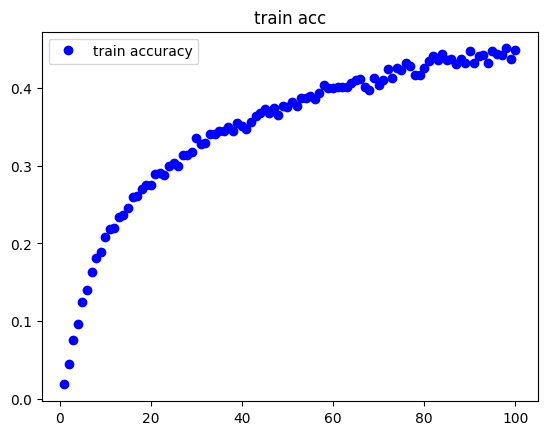

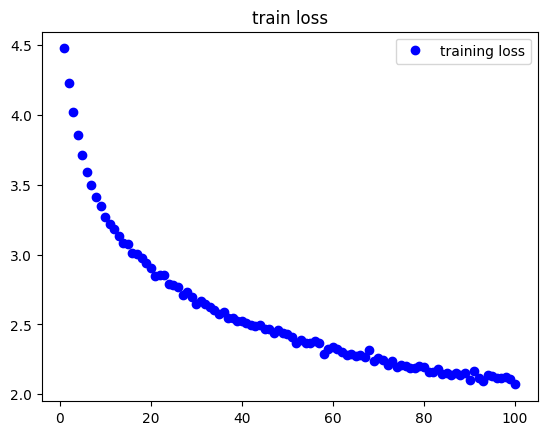

In [10]:
acc = histories[0].history['acc']
for i in range(1, len(histories)):
    acc = np.concatenate((acc, histories[i].history['acc']))

loss = histories[0].history['loss']
for i in range(1, len(histories)):
    loss = np.concatenate((loss, histories[i].history['loss']))
# Save the model

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="train accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.title("train loss")
plt.legend()

plt.show()

In [12]:
test_datagen = ImageDataGenerator(1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(HYPERPARAMETERS["img_width"], HYPERPARAMETERS["img_height"]),
    batch_size=20,
    class_mode="binary",
)

test_loss, test_acc = model.evaluate(test_generator, steps=25)
print("\ntest acc :\n", test_acc)

Found 1080 images belonging to 90 classes.


/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - acc: 0.0763 - loss: 3530.2253

test acc :
 0.06199999898672104
